# Face Recognition: MTCNN + ResNet50

## Pipeline:
1. **Crop Face** menggunakan MTCNN dari training dataset
2. **Extract Embeddings** menggunakan ResNet50
3. **Train/Validation Split** (80:20)
4. **Save Model** ke folder models/
5. **Load Model** pilihan user
6. **Test** dengan crop face dan prediction

---

In [4]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

## 1. Import Libraries

In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

# Buat folder models jika belum ada
models_dir = os.path.join(os.getcwd(), 'models')
os.makedirs(models_dir, exist_ok=True)
os.environ['TORCH_HOME'] = models_dir

# Load MTCNN untuk face detection & cropping
print("\n📸 Loading MTCNN...")
mtcnn = MTCNN(
    image_size=160, 
    margin=20, 
    device=device,
    keep_all=False,
    post_process=True
)
print("✅ MTCNN loaded!")

# Load ResNet50 untuk feature extraction
print("\n🧠 Loading ResNet50...")
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
resnet.eval()
resnet.to(device)
print("✅ ResNet50 loaded!")

# Transform untuk ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

🖥️  Device: cpu

📸 Loading MTCNN...
✅ MTCNN loaded!

🧠 Loading ResNet50...
✅ ResNet50 loaded!
✅ ResNet50 loaded!


## 2. Load Models (MTCNN + ResNet50)

In [6]:
# Configuration
data_dir = "../train/train"
test_dir = "../test"
validation_split = 0.2
random_seed = 42

print(f"📁 Training data directory: {data_dir}")
print(f"📁 Test data directory: {test_dir}")
print(f"📊 Validation split: {validation_split*100}%")

📁 Training data directory: ../train/train
📁 Test data directory: ../test
📊 Validation split: 20.0%


## 3. Fungsi Crop Face & Extract Embedding

In [7]:
def crop_face(image_path):
    """
    Crop wajah dari gambar menggunakan MTCNN
    Returns: face tensor (3, 160, 160) atau None jika tidak detect
    """
    try:
        image = Image.open(image_path).convert('RGB')
        face = mtcnn(image)
        return face
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

def extract_embedding(face_tensor):
    """
    Extract embedding 2048-dim dari cropped face menggunakan ResNet50
    """
    if face_tensor is None:
        return None
    
    # Convert face tensor ke PIL untuk transform
    face_pil = transforms.ToPILImage()(face_tensor)
    face_input = transform(face_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        embedding = resnet(face_input)
        embedding = embedding.reshape(-1).cpu().numpy()
    
    return embedding

def visualize_cropped_faces(face_tensors, labels, title="Cropped Faces"):
    """
    Visualisasi cropped faces
    """
    n = len(face_tensors)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    
    for i, (face, label) in enumerate(zip(face_tensors, labels)):
        if face is not None:
            face_img = face.permute(1, 2, 0).cpu().numpy()
            face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())
            axes[i].imshow(face_img)
            axes[i].set_title(f"{label}", fontsize=10, fontweight='bold')
        else:
            axes[i].text(0.5, 0.5, 'No Face', ha='center', va='center')
            axes[i].set_title(f"{label} - Failed", fontsize=10, color='red')
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Fungsi crop_face() dan extract_embedding() siap!")

✅ Fungsi crop_face() dan extract_embedding() siap!


## 4. Load & Crop Training Dataset

In [8]:
print("🚀 Memulai proses crop faces dari training dataset...")
print("=" * 70)

embeddings = []
labels = []
cropped_samples = []  # Untuk menyimpan 2 contoh

success_count = 0
fail_count = 0

# Iterasi setiap person folder
for person_name in os.listdir(data_dir):
    person_folder = os.path.join(data_dir, person_name)
    
    if not os.path.isdir(person_folder):
        continue
    
    print(f"\n📂 Processing: {person_name}")
    
    # Iterasi setiap gambar
    for img_file in os.listdir(person_folder):
        img_path = os.path.join(person_folder, img_file)
        
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue
        
        # Crop face
        face_tensor = crop_face(img_path)
        
        if face_tensor is not None:
            # Extract embedding
            embedding = extract_embedding(face_tensor)
            
            if embedding is not None:
                embeddings.append(embedding)
                labels.append(person_name)
                success_count += 1
                
                # Simpan 2 contoh pertama untuk visualisasi
                if len(cropped_samples) < 2:
                    cropped_samples.append({
                        'face': face_tensor,
                        'label': person_name,
                        'file': img_file
                    })
        else:
            fail_count += 1
            print(f"  ⚠️  No face detected: {img_file}")

print("\n" + "=" * 70)
print(f"✅ Success: {success_count} faces")
print(f"❌ Failed: {fail_count} images")
print(f"📊 Total embeddings: {len(embeddings)}")
print(f"👥 Total unique persons: {len(set(labels))}")

🚀 Memulai proses crop faces dari training dataset...

📂 Processing: Abraham Ganda Napitu
  ⚠️  No face detected: IMG_2138 - Abraham Ganda Napitu.jpeg
  ⚠️  No face detected: IMG_2138 - Abraham Ganda Napitu.jpeg

📂 Processing: Abu Bakar Siddiq Siregar

📂 Processing: Abu Bakar Siddiq Siregar

📂 Processing: Ahmad Faqih Hasani

📂 Processing: Ahmad Faqih Hasani

📂 Processing: Aldi Sanjaya

📂 Processing: Aldi Sanjaya
  ⚠️  No face detected: IMG_2042 - ALDI SANJAYA.jpeg
  ⚠️  No face detected: IMG_2042 - ALDI SANJAYA.jpeg
  ⚠️  No face detected: IMG_3149 - ALDI SANJAYA.jpeg
  ⚠️  No face detected: IMG_3149 - ALDI SANJAYA.jpeg
  ⚠️  No face detected: IMG_3151 - ALDI SANJAYA.jpeg

📂 Processing: Alfajar
  ⚠️  No face detected: IMG_3151 - ALDI SANJAYA.jpeg

📂 Processing: Alfajar

📂 Processing: Alief Fathur Rahman

📂 Processing: Alief Fathur Rahman

📂 Processing: Arkan Hariz Chandrawinata Liem

📂 Processing: Arkan Hariz Chandrawinata Liem

📂 Processing: Bayu Ega Ferdana

📂 Processing: Bayu Ega Fer

### 4.1 Visualisasi 2 Contoh Cropped Faces

Berikut adalah 2 contoh hasil cropping wajah untuk memastikan area yang di-crop sudah benar:

📸 Contoh hasil cropping wajah dari training data:



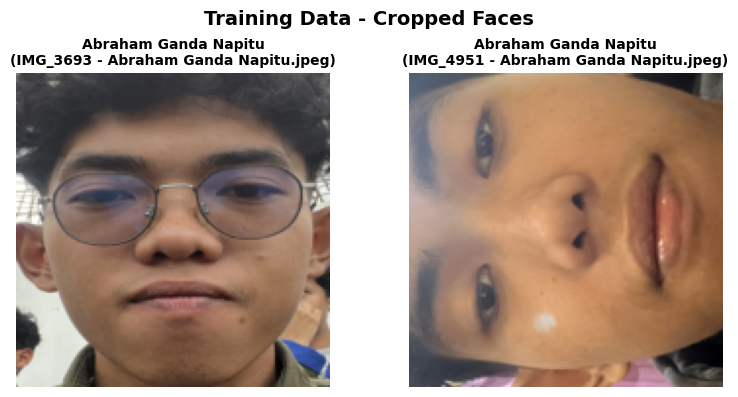

In [9]:
# Tampilkan 2 contoh cropped faces
if len(cropped_samples) >= 2:
    print("📸 Contoh hasil cropping wajah dari training data:\n")
    
    face_tensors = [sample['face'] for sample in cropped_samples]
    face_labels = [f"{sample['label']}\n({sample['file']})" for sample in cropped_samples]
    
    visualize_cropped_faces(face_tensors, face_labels, "Training Data - Cropped Faces")
else:
    print("⚠️ Tidak cukup data untuk visualisasi")

## 5. Train/Validation Split

In [11]:
# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

print(f"📊 Data shape:")
print(f"   Embeddings: {embeddings.shape}")
print(f"   Labels: {labels.shape}")

# Check for classes with only 1 sample
from collections import Counter
label_counts = Counter(labels)
min_samples = min(label_counts.values())

# Split train/validation with or without stratify based on data distribution
if min_samples >= 2:
    # Use stratified split if all classes have at least 2 samples
    train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
        embeddings, labels,
        test_size=validation_split,
        random_state=random_seed,
        stratify=labels
    )
    print(f"✅ Using stratified split (all classes have ≥2 samples)")
else:
    # Use regular split if some classes have only 1 sample
    train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
        embeddings, labels,
        test_size=validation_split,
        random_state=random_seed,
        stratify=None
    )
    print(f"⚠️  Using regular split (some classes have only 1 sample)")
    print(f"   Classes with 1 sample: {sum(1 for count in label_counts.values() if count == 1)}")

print(f"\n✅ Split completed:")
print(f"   Training: {len(train_embeddings)} samples ({(1-validation_split)*100:.0f}%)")
print(f"   Validation: {len(val_embeddings)} samples ({validation_split*100:.0f}%)")
print(f"   Train persons: {len(set(train_labels))}")
print(f"   Val persons: {len(set(val_labels))}")

📊 Data shape:
   Embeddings: (243, 2048)
   Labels: (243,)
⚠️  Using regular split (some classes have only 1 sample)
   Classes with 1 sample: 3

✅ Split completed:
   Training: 194 samples (80%)
   Validation: 49 samples (20%)
   Train persons: 67
   Val persons: 38


## 6. Validasi Model

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def validate_model(train_emb, train_lbl, val_emb, val_lbl, threshold=0.6):
    """
    Validasi model menggunakan validation set
    """
    print("🔍 Validating model on validation set...")
    print("=" * 70)
    
    predictions = []
    
    for val_embedding in val_emb:
        val_embedding_reshaped = val_embedding.reshape(1, -1)
        
        # Hitung similarity dengan semua training embeddings
        similarities = cosine_similarity(val_embedding_reshaped, train_emb)[0]
        max_idx = np.argmax(similarities)
        max_similarity = similarities[max_idx]
        
        # Predict
        if max_similarity >= threshold:
            predictions.append(train_lbl[max_idx])
        else:
            predictions.append("Unknown")
    
    # Calculate metrics
    accuracy = accuracy_score(val_lbl, predictions)
    precision = precision_score(val_lbl, predictions, average='weighted', zero_division=0)
    recall = recall_score(val_lbl, predictions, average='weighted', zero_division=0)
    f1 = f1_score(val_lbl, predictions, average='weighted', zero_division=0)
    
    print(f"\n📊 Validation Results:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    # Count errors
    errors = sum([1 for true, pred in zip(val_lbl, predictions) if true != pred])
    print(f"\n   Total errors: {errors}/{len(val_lbl)}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': predictions
    }

# Jalankan validasi
validation_results = validate_model(
    train_embeddings, train_labels,
    val_embeddings, val_labels,
    threshold=0.6
)

🔍 Validating model on validation set...

📊 Validation Results:
   Accuracy:  0.4286 (42.86%)
   Precision: 0.4048
   Recall:    0.4286
   F1-Score:  0.4068

   Total errors: 28/49


d:\deeplearning\Tubes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
d:\deeplearning\Tubes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\deeplearning\Tubes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
d:\deeplearning\Tubes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWa

## 7. Save Model

In [13]:
from datetime import datetime

# Buat nama model dengan timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"face_recognition_model_{timestamp}.pkl"
model_path = os.path.join(models_dir, model_name)

# Save model data
model_data = {
    'train_embeddings': train_embeddings,
    'train_labels': train_labels,
    'val_embeddings': val_embeddings,
    'val_labels': val_labels,
    'validation_results': validation_results,
    'timestamp': timestamp,
    'num_persons': len(set(train_labels)),
    'num_samples': len(train_embeddings)
}

with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"💾 Model saved successfully!")
print(f"   Path: {model_path}")
print(f"   Size: {os.path.getsize(model_path) / 1024:.2f} KB")
print(f"   Persons: {model_data['num_persons']}")
print(f"   Samples: {model_data['num_samples']}")

💾 Model saved successfully!
   Path: d:\deeplearning\Tubes\src\models\face_recognition_model_20251126_200511.pkl
   Size: 1979.46 KB
   Persons: 67
   Samples: 194


## 8. Load Model (User Choice)

In [14]:
# List semua model yang tersedia
print("📂 Available models in 'models/' folder:\n")

model_files = [f for f in os.listdir(models_dir) if f.endswith('.pkl')]

if not model_files:
    print("❌ No models found! Please train a model first.")
else:
    for i, model_file in enumerate(model_files, 1):
        model_path_temp = os.path.join(models_dir, model_file)
        size_kb = os.path.getsize(model_path_temp) / 1024
        print(f"   [{i}] {model_file} ({size_kb:.2f} KB)")
    
    print("\n" + "=" * 70)
    
    # User memilih model (untuk testing, kita pilih yang terbaru)
    selected_model = model_files[-1]  # Pilih model terbaru
    print(f"✅ Selected model: {selected_model}")
    
    # Load selected model
    selected_model_path = os.path.join(models_dir, selected_model)
    
    with open(selected_model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    
    # Extract data dari model
    loaded_train_embeddings = loaded_model['train_embeddings']
    loaded_train_labels = loaded_model['train_labels']
    
    print(f"\n📊 Model info:")
    print(f"   Timestamp: {loaded_model['timestamp']}")
    print(f"   Persons: {loaded_model['num_persons']}")
    print(f"   Samples: {loaded_model['num_samples']}")
    print(f"   Validation Accuracy: {loaded_model['validation_results']['accuracy']:.4f}")

📂 Available models in 'models/' folder:

   [1] face_recognition_model_20251126_200511.pkl (1979.46 KB)

✅ Selected model: face_recognition_model_20251126_200511.pkl

📊 Model info:
   Timestamp: 20251126_200511
   Persons: 67
   Samples: 194
   Validation Accuracy: 0.4286


## 9. Testing dengan Test Dataset

In [15]:
# Load test images
print("🧪 Loading test images...")
print("=" * 70)

test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

if not test_images:
    print("❌ No test images found in", test_dir)
else:
    print(f"✅ Found {len(test_images)} test images")
    
    test_results = []
    
    # Process setiap test image
    for img_file in test_images:
        img_path = os.path.join(test_dir, img_file)
        print(f"\n📸 Processing: {img_file}")
        
        # Crop face
        face_tensor = crop_face(img_path)
        
        if face_tensor is None:
            print(f"   ❌ No face detected")
            test_results.append({
                'file': img_file,
                'face': None,
                'prediction': 'No Face Detected',
                'similarity': 0.0
            })
            continue
        
        # Extract embedding
        test_embedding = extract_embedding(face_tensor)
        
        if test_embedding is None:
            print(f"   ❌ Failed to extract embedding")
            continue
        
        # Compare with training data
        test_embedding_reshaped = test_embedding.reshape(1, -1)
        similarities = cosine_similarity(test_embedding_reshaped, loaded_train_embeddings)[0]
        
        max_idx = np.argmax(similarities)
        max_similarity = similarities[max_idx]
        
        # Predict dengan threshold
        threshold = 0.6
        if max_similarity >= threshold:
            predicted_name = loaded_train_labels[max_idx]
        else:
            predicted_name = "Unknown"
        
        print(f"   🎯 Prediction: {predicted_name}")
        print(f"   📊 Similarity: {max_similarity:.4f}")
        
        test_results.append({
            'file': img_file,
            'face': face_tensor,
            'prediction': predicted_name,
            'similarity': max_similarity
        })
    
    print("\n" + "=" * 70)
    print(f"✅ Testing completed: {len(test_results)} images processed")

🧪 Loading test images...
✅ Found 8 test images

📸 Processing: 1.jpg
   🎯 Prediction: Reynaldi Cristian Simamora
   📊 Similarity: 0.7953

📸 Processing: 2.jpg
   🎯 Prediction: Reynaldi Cristian Simamora
   📊 Similarity: 0.7953

📸 Processing: 2.jpg
   🎯 Prediction: Royfran Roger Valentino
   📊 Similarity: 0.8439

📸 Processing: 3.jpg
   🎯 Prediction: Royfran Roger Valentino
   📊 Similarity: 0.8439

📸 Processing: 3.jpg
   🎯 Prediction: Bintang Fikri Fauzan
   📊 Similarity: 1.0000

📸 Processing: 4.png
   🎯 Prediction: William Chan
   📊 Similarity: 0.8222

📸 Processing: 5.jpg
   🎯 Prediction: Bintang Fikri Fauzan
   📊 Similarity: 1.0000

📸 Processing: 4.png
   🎯 Prediction: William Chan
   📊 Similarity: 0.8222

📸 Processing: 5.jpg
   🎯 Prediction: William Chan
   📊 Similarity: 1.0000

📸 Processing: 6.png
   🎯 Prediction: Ichsan Kuntadi Baskara
   📊 Similarity: 0.7490

📸 Processing: 7.png
   🎯 Prediction: William Chan
   📊 Similarity: 1.0000

📸 Processing: 6.png
   🎯 Prediction: Ichsan Kuntadi

### 9.1 Visualisasi 5 Test Results (Cropped Faces)

Berikut adalah 5 foto hasil cropping dari test dataset beserta prediksinya:

📊 Menampilkan 5 hasil test (cropped faces):



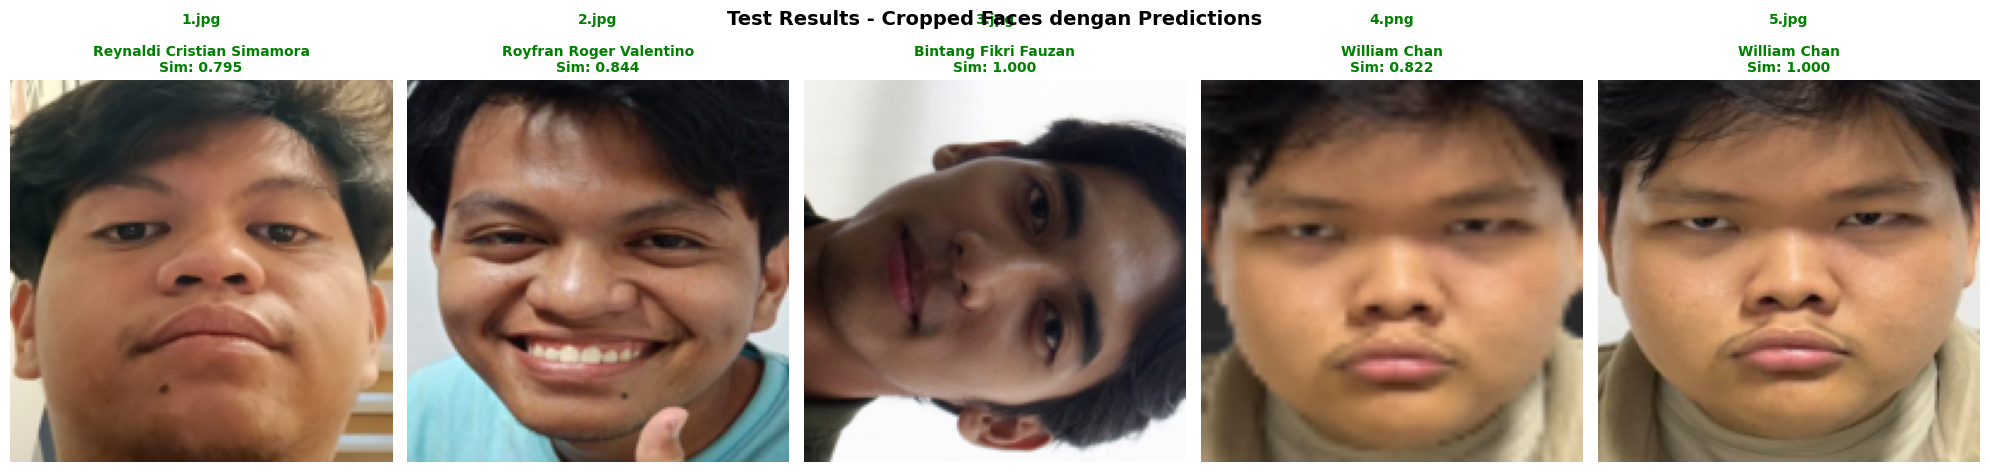


📋 Test Summary:
✅ [1] 1.jpg                          → Reynaldi Cristian Simamora (Sim: 0.795)
✅ [2] 2.jpg                          → Royfran Roger Valentino (Sim: 0.844)
✅ [3] 3.jpg                          → Bintang Fikri Fauzan (Sim: 1.000)
✅ [4] 4.png                          → William Chan         (Sim: 0.822)
✅ [5] 5.jpg                          → William Chan         (Sim: 1.000)


In [33]:
# Tampilkan 5 test results
num_to_show = min(5, len(test_results))

if num_to_show > 0:
    print(f"📊 Menampilkan {num_to_show} hasil test (cropped faces):\n")
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(4*num_to_show, 5))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        result = test_results[i]
        
        if result['face'] is not None:
            # Tampilkan cropped face
            face_img = result['face'].permute(1, 2, 0).cpu().numpy()
            face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())
            axes[i].imshow(face_img)
            
            # Tentukan warna berdasarkan prediction
            color = 'green' if result['prediction'] not in ['Unknown', 'No Face Detected'] else 'red'
            
            # Title dengan info lengkap
            title = f"{result['file'][:15]}\n\n{result['prediction']}\nSim: {result['similarity']:.3f}"
            axes[i].set_title(title, fontsize=10, fontweight='bold', color=color)
        else:
            axes[i].text(0.5, 0.5, 'No Face\nDetected', ha='center', va='center', 
                        fontsize=12, color='red', fontweight='bold')
            axes[i].set_title(result['file'][:15], fontsize=10)
        
        axes[i].axis('off')
    
    plt.suptitle('Test Results - Cropped Faces dengan Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 70)
    print("📋 Test Summary:")
    print("=" * 70)
    
    for i, result in enumerate(test_results[:num_to_show], 1):
        status = "✅" if result['face'] is not None else "❌"
        print(f"{status} [{i}] {result['file'][:30]:<30} → {result['prediction']:<20} (Sim: {result['similarity']:.3f})")
else:
    print("⚠️ Tidak ada test results untuk ditampilkan")

### 9.2 (Optional) Test Single Image dengan Detail

📸 Testing: 12.png


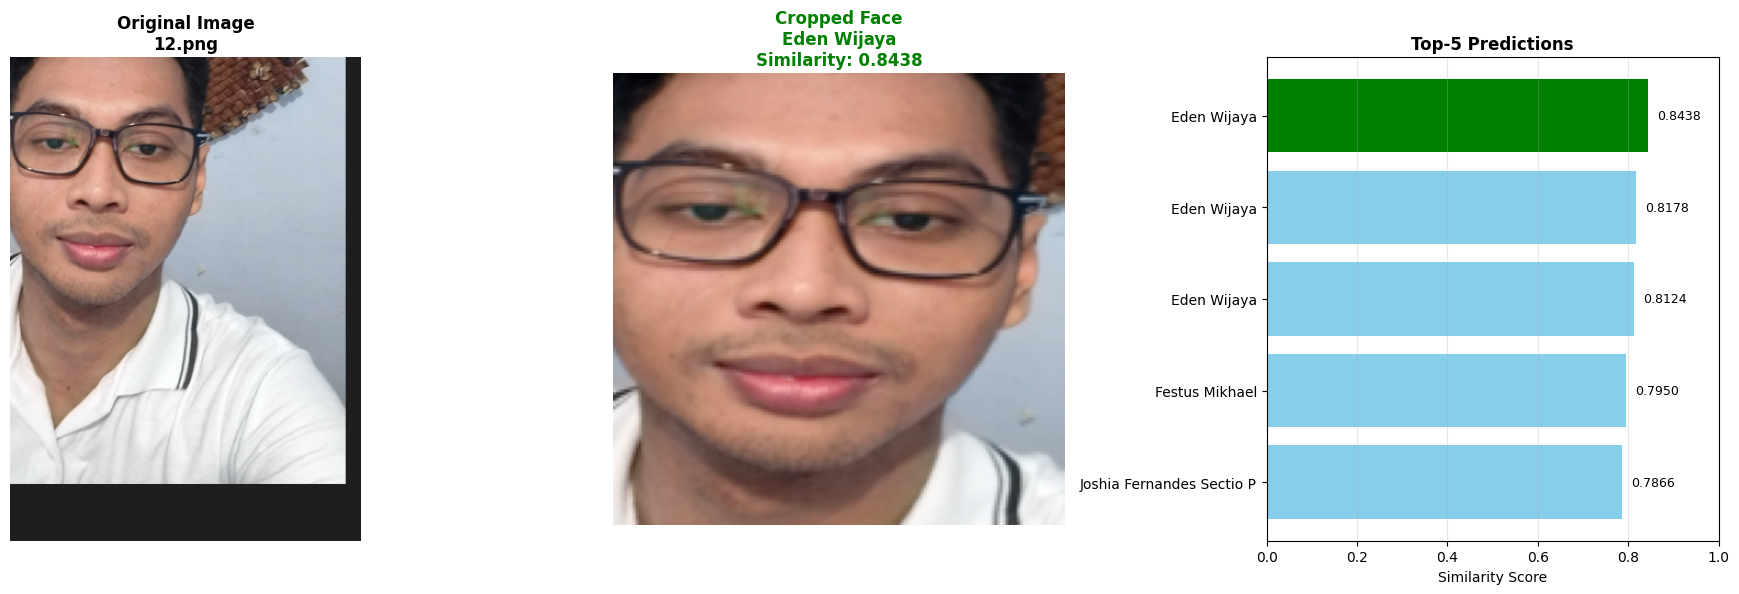


🎯 Final Prediction: Eden Wijaya
📊 Similarity Score: 0.8438


In [37]:
# Test single image dengan visualisasi detail
def test_single_image_detail(image_path, model_embeddings, model_labels, threshold=0.6):
    """
    Test single image dengan visualisasi original + cropped + top predictions
    """
    if not os.path.exists(image_path):
        print(f"❌ File not found: {image_path}")
        return
    
    print(f"📸 Testing: {os.path.basename(image_path)}")
    
    # Load original image
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Crop face
    face_tensor = crop_face(image_path)
    
    if face_tensor is None:
        print("❌ No face detected!")
        plt.figure(figsize=(8, 6))
        plt.imshow(original_img_rgb)
        plt.title("Original Image - No Face Detected", color='red', fontweight='bold')
        plt.axis('off')
        plt.show()
        return
    
    # Extract embedding
    test_embedding = extract_embedding(face_tensor)
    
    # Compare
    test_embedding_reshaped = test_embedding.reshape(1, -1)
    similarities = cosine_similarity(test_embedding_reshaped, model_embeddings)[0]
    
    # Get top 5
    top_5_indices = np.argsort(similarities)[-5:][::-1]
    top_5_names = [model_labels[i] for i in top_5_indices]
    top_5_scores = [similarities[i] for i in top_5_indices]
    
    # Prediction
    max_similarity = top_5_scores[0]
    prediction = top_5_names[0] if max_similarity >= threshold else "Unknown"
    
    # Visualisasi
    fig = plt.figure(figsize=(18, 6))
    
    # Plot 1: Original
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(original_img_rgb)
    ax1.set_title(f"Original Image\n{os.path.basename(image_path)}", fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Plot 2: Cropped face
    ax2 = plt.subplot(1, 3, 2)
    face_img = face_tensor.permute(1, 2, 0).cpu().numpy()
    face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())
    ax2.imshow(face_img)
    color = 'green' if prediction != "Unknown" else 'red'
    ax2.set_title(f"Cropped Face\n{prediction}\nSimilarity: {max_similarity:.4f}", 
                  fontsize=12, fontweight='bold', color=color)
    ax2.axis('off')
    
    # Plot 3: Top 5 predictions
    ax3 = plt.subplot(1, 3, 3)
    colors = ['green' if i == 0 else 'skyblue' for i in range(5)]
    y_pos = np.arange(5)
    ax3.barh(y_pos, top_5_scores, color=colors)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([name[:25] for name in top_5_names])
    ax3.invert_yaxis()
    ax3.set_xlabel('Similarity Score')
    ax3.set_title('Top-5 Predictions', fontsize=12, fontweight='bold')
    ax3.set_xlim([0, 1])
    ax3.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(top_5_scores):
        ax3.text(v + 0.02, i, f'{v:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 Final Prediction: {prediction}")
    print(f"📊 Similarity Score: {max_similarity:.4f}")

# Contoh penggunaan (uncomment untuk test)
test_single_image_detail("../test/12.png", loaded_train_embeddings, loaded_train_labels)

---

## 📝 Summary

### ✅ Pipeline yang Telah Diimplementasikan:

1. **Crop Face dengan MTCNN**: Semua gambar training di-crop wajahnya terlebih dahulu
2. **Extract Embeddings**: ResNet50 extract 2048-dim embeddings dari cropped faces
3. **Train/Val Split**: 80% training, 20% validation (stratified)
4. **Validation**: Model divalidasi dengan accuracy, precision, recall, F1-score
5. **Save Model**: Model disimpan ke folder `models/` dengan timestamp
6. **Load Model**: User dapat memilih model mana yang akan digunakan
7. **Testing**: 
   - Crop wajah dari test images menggunakan MTCNN
   - Predict menggunakan cosine similarity
   - Visualisasi 5 cropped faces dengan predictions

### 🎯 Keunggulan Pipeline:

- ✅ MTCNN memastikan hanya wajah yang di-crop (bukan background)
- ✅ Face alignment meningkatkan consistency untuk ResNet50
- ✅ Visualisasi cropped faces memastikan area yang benar
- ✅ Model tersimpan dan dapat di-load kapan saja
- ✅ Validation metrics untuk objektif evaluation

### 📊 Output:

1. **2 Contoh Training Crops**: Memastikan cropping benar saat training
2. **Validation Metrics**: Accuracy, Precision, Recall, F1-Score
3. **5 Test Results**: Cropped faces dengan predictions dan similarity scores
4. **Saved Model**: File .pkl berisi embeddings dan metadata